In [1]:
import pandas as pd

#Load data
cab_data_df = pd.read_csv('DataSets-main/Cab_Data.csv')
cab_data_df['Date of Travel'] =  pd.to_datetime(cab_data_df['Date of Travel'].astype(int), unit='D', origin='1899-12-30')

customer_id_df = pd.read_csv('DataSets-main/Customer_ID.csv')
transaction_id_df = pd.read_csv('DataSets-main/Transaction_ID.csv')

city_df = pd.read_csv('DataSets-main/City.csv')
city_df['Population'] = city_df['Population'].astype(str).str.replace(',', '').astype(int)
city_df['Users'] = city_df['Users'].astype(str).str.replace(',', '').astype(int)

#Merge dataframes
cab_data_transaction_df = pd.merge( transaction_id_df, cab_data_df, on="Transaction ID")
cab_transaction_customer_df = pd.merge(customer_id_df, cab_data_transaction_df, on="Customer ID")

#Add profit column
cab_transaction_customer_df['Profit'] = cab_transaction_customer_df['Price Charged'] - cab_transaction_customer_df['Cost of Trip']

cab_transaction_customer_df.index.freq = 'D'
cab_transaction_customer_df.head()

,Customer ID,Gender,Age,Income (USD/Month),Transaction ID,Payment_Mode,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Profit
0,29290,Male,28,10813,10000011,Card,2016-01-08,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,57.3150
1,29290,Male,28,10813,10351127,Cash,2018-07-21,Yellow Cab,ATLANTA GA,26.19,598.70,317.4228,281.2772
2,29290,Male,28,10813,10412921,Card,2018-11-23,Yellow Cab,ATLANTA GA,42.55,792.05,597.4020,194.6480
3,27703,Male,27,9237,10000012,Card,2016-01-06,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,23.6660
4,27703,Male,27,9237,10320494,Card,2018-04-21,Yellow Cab,ATLANTA GA,36.38,721.10,467.1192,253.9808


In [2]:
#We will divide the dataframe for the 2 companies

pink_cab_df = cab_transaction_customer_df[cab_transaction_customer_df['Company']=='Pink Cab']
yellow_cab_df =cab_transaction_customer_df[cab_transaction_customer_df['Company']=='Yellow Cab']

#We only need the Date of Travel and the Profit column
pink_cab_df = pink_cab_df[['Date of Travel', 'Profit']].groupby(by="Date of Travel").sum()
yellow_cab_df = yellow_cab_df[['Date of Travel', 'Profit']].groupby(by="Date of Travel").sum()

yellow_cab_df.head()

,Profit
Date of Travel,
2016-01-02,45295.6412
2016-01-03,38449.5288
2016-01-04,3650.2012
2016-01-05,11338.1156
2016-01-06,18663.4464


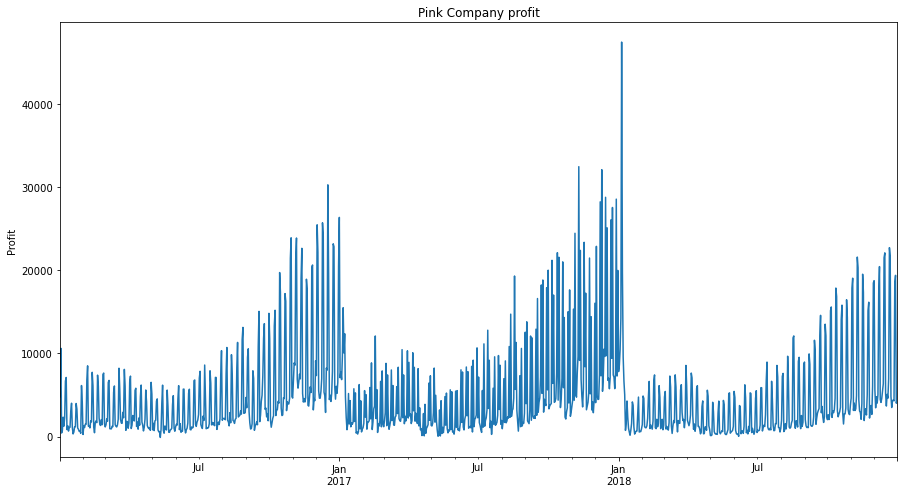

In [3]:
#Plot the total profit for the Pink company

title = 'Pink Company profit'
ylabel='Profit'
xlabel='' # we don't really need a label here

ax = pink_cab_df['Profit'].plot(figsize=(15,8),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);


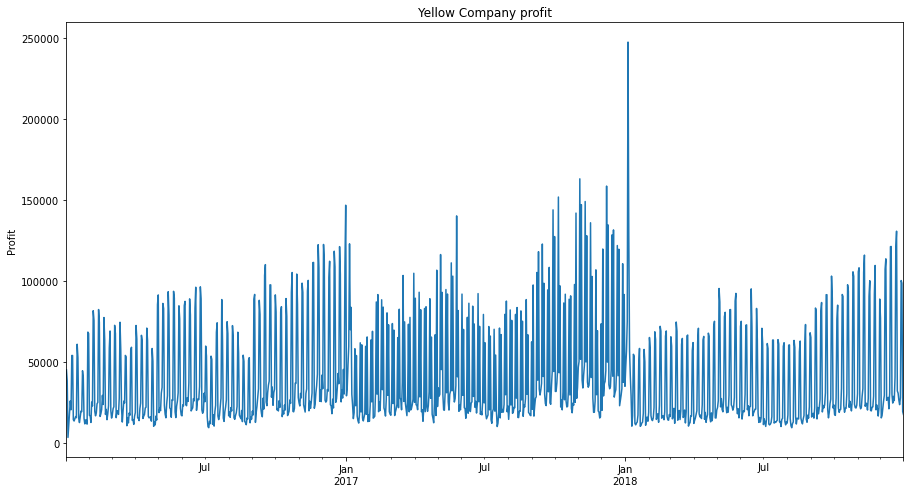

In [4]:
#Plot the total profit for the Yellow company

title = 'Yellow Company profit'
ylabel='Profit'
xlabel='' # we don't really need a label here

ax = yellow_cab_df['Profit'].plot(figsize=(15,8),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

**Run an ETS demcomposition (Error-Trend-Seasonality)**

ETS for the Pink company

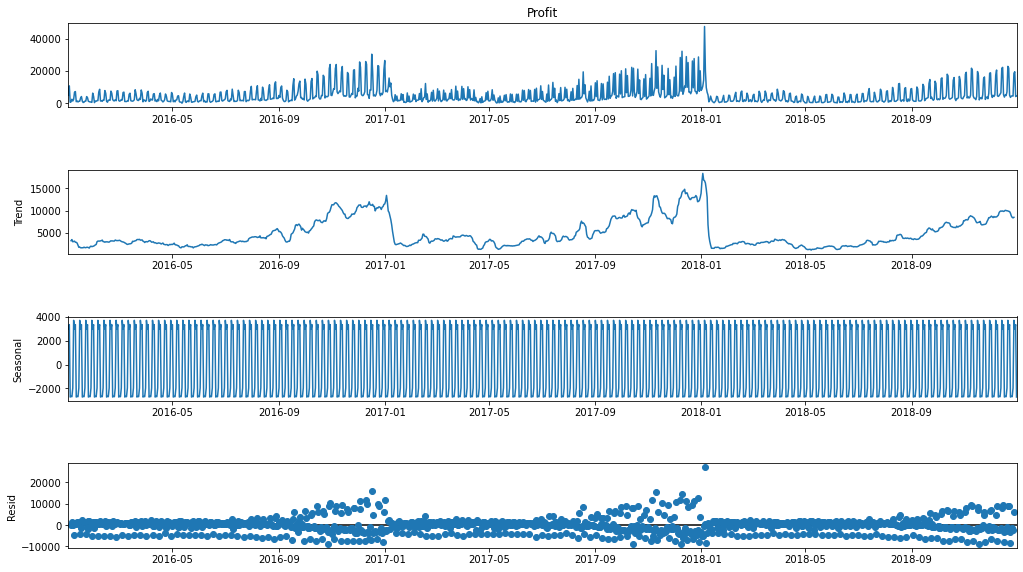

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plot

pink_decomp = seasonal_decompose(pink_cab_df['Profit'], model='add')
pink_decomp.plot().set_size_inches(16,9);

<AxesSubplot:xlabel='Date of Travel'>

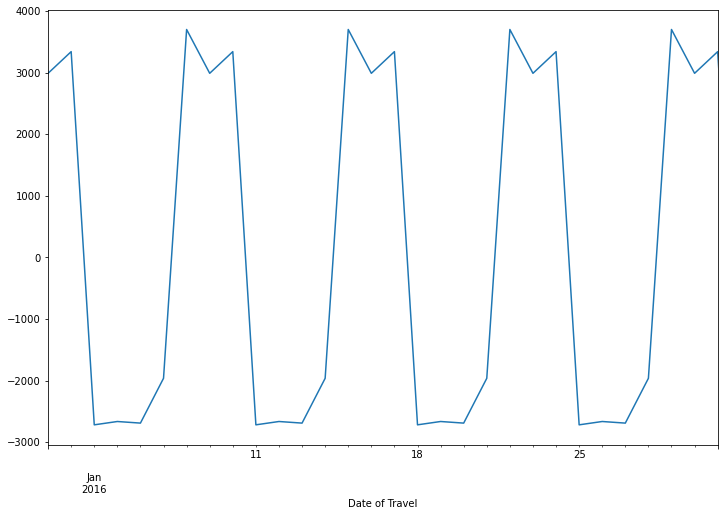

In [6]:
#Looking for seasonality in the seasonal component

pink_decomp.seasonal.plot(figsize=(12,8), xlim=(('2016-01-02','2016-01-31')))

**We see there is a weekly seasonality which makes total sense**

ETS for the Yellow company

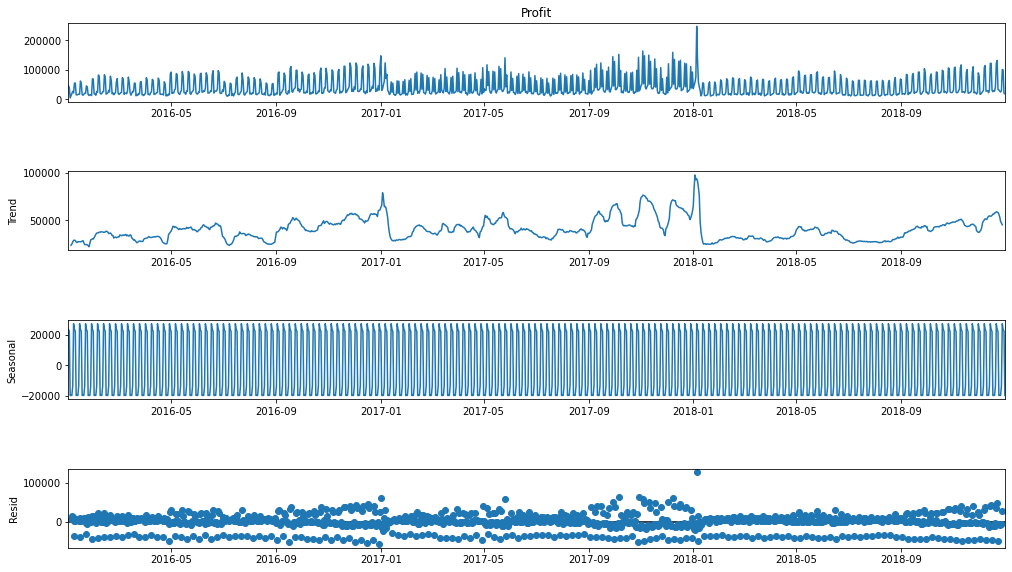

In [7]:
yellow_decomp = seasonal_decompose(yellow_cab_df['Profit'], model='add')
yellow_decomp.plot().set_size_inches(16,9);

<AxesSubplot:xlabel='Date of Travel'>

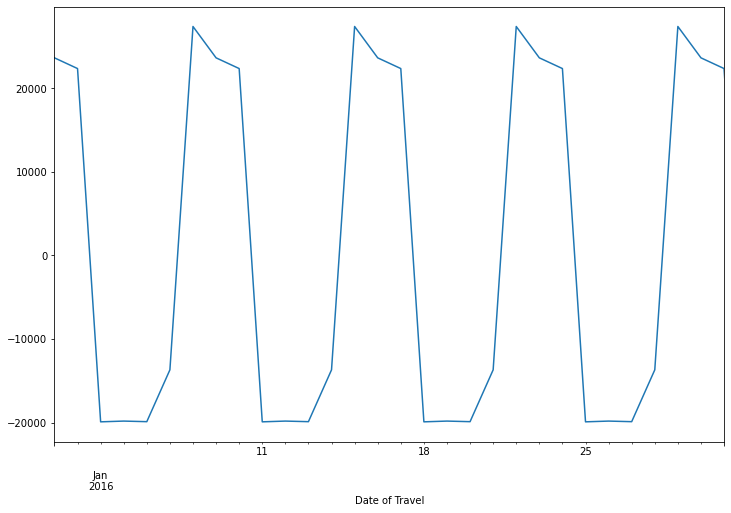

In [8]:
yellow_decomp.seasonal.plot(figsize=(12,8), xlim=(('2016-01-02','2016-01-31')))

**Run auto_arima to get the orders for the model (Yellow cab)**

In [10]:
from pmdarima import auto_arima     #To determine ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

auto_arima(yellow_cab_df['Profit'],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1095
Model:             SARIMAX(5, 1, 2)x(1, 0, [1], 7)   Log Likelihood              -11815.739
Date:                             Mon, 20 Jun 2022   AIC                          23653.479
Time:                                     15:37:36   BIC                          23708.453
Sample:                                          0   HQIC                         23674.281
                                            - 1095                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.9611     18.531      0.538      0.591     -26.359      46.281
ar.L1         -0.3379      0.144     -2.345      0.019      -0.620      -0.055
ar.L2          0.4269      0.063      6.819      0.000       0.304       0.550
ar.L3          0.1813      0.042      4.285      0.000       0.098       0.264
ar.L4          0.0729      0.044      1.654      0.098      -0.013       0.159
ar.L5          0.0904      0.034      2.636      0.008       0.023       0.158
ma.L1         -0.1819      0.140     -1.300      0.194      -0.456       0.092
ma.L2         -0.7805      0.120     -6.491      0.000      -1.016      -0.545
ar.S.L7        0.9676      0.009    102.047      0.000       0.949       0.986
ma.S.L7       -0.4061      0.028    -14.408      0.000      -0.461      -0.351
sigma2       1.93e+08   5.23e-06   3.69e+13      0.000    1.93e+08    1.93e+08
===================================================================================
Ljung-Box (L1) (Q):                   3.22   Jarque-Bera (JB):             34045.76
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               2.33   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.22e+28. Standard errors may be unstable.
"""

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(yellow_cab_df['Profit'],order=(5,1,2),seasonal_order=(1,0,1,7))
results = model.fit()
fcast = results.predict(len(yellow_cab_df),len(yellow_cab_df)+365,typ='levels').rename('SARIMA(5,1,2)(1,0,1,7) Forecast')

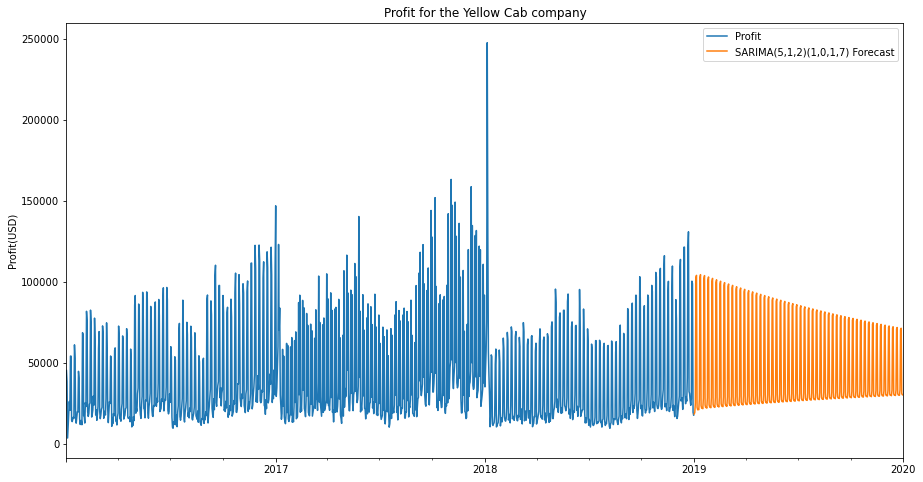

In [12]:
# Plot predictions against known values
title = 'Profit for the Yellow Cab company'
ylabel='Profit(USD)'
xlabel=''

ax = yellow_cab_df['Profit'].plot(legend=True,figsize=(15,8),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## We see that our model predicts correctly the 7 days seasonality but it is completely ignoring the 365 days seasonality, to solve the problem of having 2 seasonalities (365 and 7) we will add Fourier terms as exogenous variables

**Run auto_arima with exogenous variables to get the orders for the model (Yellow cab)**

In [45]:
import numpy as np
from datetime import timedelta

#Fourier terms
idx = pd.date_range(yellow_cab_df.index[-1],yellow_cab_df.index[-1]+timedelta(days=365)).union(yellow_cab_df.index)
exog = pd.DataFrame({'Date of Travel': idx})
exog = exog.set_index(pd.PeriodIndex(exog['Date of Travel'], freq='D'))
exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365.25)

#Additional fourier terms
#exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365.25)
#exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365.25)
#exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365.25)

exog = exog.drop(columns=['Date of Travel'])

yellow_arima_exog = auto_arima(yellow_cab_df['Profit'],seasonal=True, m=7, exogenous=exog[:-365], max_P=7, start_P=6 ,max_Q=4 , start_Q=3, start_p=1, start_q=1)
yellow_arima_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1095
Model:             SARIMAX(5, 0, 3)x(4, 0, 3, 7)   Log Likelihood              -11844.515
Date:                           Mon, 20 Jun 2022   AIC                          23725.031
Time:                                   16:50:20   BIC                          23815.004
Sample:                               01-02-2016   HQIC                         23759.076
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.034e+04   1.11e+04      0.929      0.353   -1.15e+04    3.21e+04
sin365     -5031.7314   9569.796     -0.526      0.599   -2.38e+04    1.37e+04
ar.L1         -2.0608      0.221     -9.312      0.000      -2.495      -1.627
ar.L2         -1.2042      0.276     -4.367      0.000      -1.745      -0.664
ar.L3          0.4981      0.059      8.487      0.000       0.383       0.613
ar.L4          0.7218      0.170      4.247      0.000       0.389       1.055
ar.L5          0.1777      0.076      2.342      0.019       0.029       0.326
ma.L1          2.4608      0.217     11.330      0.000       2.035       2.887
ma.L2          2.2913      0.348      6.582      0.000       1.609       2.974
ma.L3          0.7894      0.168      4.704      0.000       0.460       1.118
ar.S.L7       -0.1372      0.265     -0.519      0.604      -0.656       0.381
ar.S.L14       0.3125      0.248      1.259      0.208      -0.174       0.799
ar.S.L21       0.6753      0.222      3.042      0.002       0.240       1.110
ar.S.L28       0.0814      0.091      0.891      0.373      -0.098       0.261
ma.S.L7        0.6096      0.264      2.306      0.021       0.092       1.128
ma.S.L14       0.2150      0.224      0.958      0.338      -0.225       0.655
ma.S.L21      -0.3466      0.141     -2.452      0.014      -0.624      -0.070
sigma2      2.219e+08      2.894   7.67e+07      0.000    2.22e+08    2.22e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             27535.95
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               2.40   Skew:                             0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.57e+22. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='Date of Travel'>

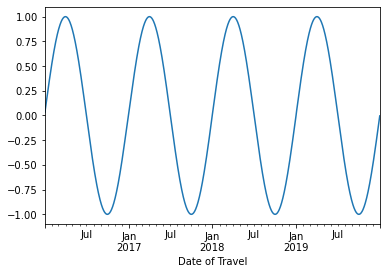

In [46]:
#Exogenous variables (it has 1 additional year because we will need those variables to forecast 1 year into the future)
exog['sin365'].plot()

In [47]:
fcast = yellow_arima_exog.predict(n_periods=365, exogenous=exog[-365:])

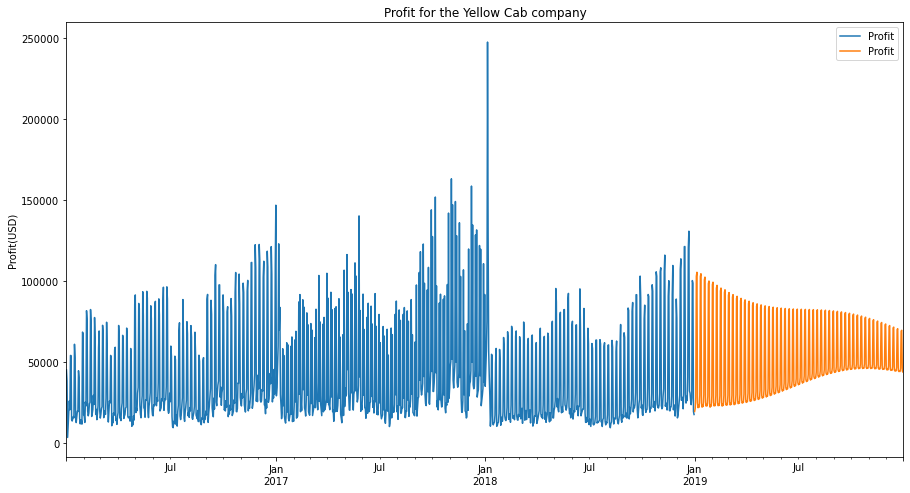

In [48]:
# Plot predictions against known values
title = 'Profit for the Yellow Cab company'
ylabel='Profit(USD)'
xlabel=''

ax = yellow_cab_df['Profit'].plot(legend=True,figsize=(15,8),title=title)
fcast_df = pd.DataFrame(fcast, columns = ['Profit'])
fcast_df = fcast_df.set_index(idx[-365:])
fcast_df.plot(legend=True, ax=ax)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## Still not good enough to make predictions, we will change the approach and calculate the revenue growth per year

**Yellow cab revenue growth profit**

In [59]:
yellow_2017 = yellow_cab_df['Profit'][365:730].sum()/yellow_cab_df['Profit'][:365].sum()
yellow_2018 = yellow_cab_df['Profit'][730:1095].sum()/yellow_cab_df['Profit'][365:730].sum()
print(f'Yellow cab revenue growth 2017: {yellow_2017 - 1: .2f}')
print(f'Yellow cab revenue growth 2018: {yellow_2018 - 1: .2f}')

Yellow cab revenue growth 2017:  0.19
Yellow cab revenue growth 2018: -0.18


**Pink cab revenue growth profit**

In [58]:
pink_2017 = pink_cab_df['Profit'][365:730].sum()/pink_cab_df['Profit'][:365].sum()
pink_2018 = pink_cab_df['Profit'][730:1095].sum()/pink_cab_df['Profit'][365:730].sum()
print(f'Pink cab revenue growth 2017: {pink_2017 - 1: .2f}')
print(f'Pink cab revenue growth 2018: {pink_2018 - 1: .2f}')

Pink cab revenue growth 2017:  0.19
Pink cab revenue growth 2018: -0.23
